In [2]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
!aws s3 ls s3://ads-508-final/playstation/

                           PRE achievements/
                           PRE games/
                           PRE history/
                           PRE players/
                           PRE prices/
                           PRE purchased_games/


In [5]:
# set path for public bucket
s3_playstation_path_public = 's3://ads-508-final/playstation/'

In [6]:
# set staging directory in private bucket
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
# create connection with pyathena
# EXPLORE USING ENGINE
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

In [8]:
# define database name
database_name = "playstationaws"

In [9]:
# create database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement) 

CREATE DATABASE IF NOT EXISTS playstationaws


In [10]:
# execute query to create database
pd.read_sql(statement, conn)

""


In [11]:
# execute query to show database is present
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,playstationaws


## Creating Players and Prices Tables in Database

In [21]:
# Create the "players" table
players_create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.players (
    playerid INT,
    nickname STRING,
    country STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '{s3_playstation_path_public}'
TBLPROPERTIES ("skip.header.line.count"="1");
"""

print(players_create_table_query)


CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.players (
    playerid INT,
    nickname STRING,
    country STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://ads-508-final/playstation/'
TBLPROPERTIES ("skip.header.line.count"="1");



In [22]:
# execute query to create table and load data
pd.read_sql(players_create_table_query, conn)

""


In [23]:
# define query and check load
statement = """select * from {}.players limit 50""".format(database_name)

In [24]:
df_players = pd.read_sql(statement, conn)
df_players.head(5)

,playerid,nickname,country
0,2744567,ieizazuBisnorog,Croatia
1,328452,DiscoGitaroo,United States
2,2521482,Ectivey,United Kingdom
3,390175,Tomie_Again,"""Korea"
4,4348945,Lordhell1986,Russian Federation


In [25]:
prices_create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.prices (
    gameid INT,
    usd DOUBLE,
    eur DOUBLE,
    gbp DOUBLE,
    jpy DOUBLE,
    rub DOUBLE,
    date_acquired STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '{s3_playstation_path_public}'
TBLPROPERTIES ("skip.header.line.count"="1");
"""

In [26]:
# execute query to create table and load data
pd.read_sql(prices_create_table_query, conn)

""


In [28]:
# define query and check load
statement_2 = """select * from {}.prices limit 50""".format(database_name)

In [29]:
df_prices = pd.read_sql(statement_2, conn)
df_prices.head(5)

,gameid,usd,eur,gbp,jpy,rub,date_acquired
0,749347,10.39,10.39,7.99,1408.0,929.0,2025-02-22
1,749281,1.49,1.49,1.19,220.0,NaN,2025-02-22
2,749839,14.99,14.99,11.99,2310.0,1069.0,2025-02-22
3,749280,1.49,1.49,1.19,220.0,NaN,2025-02-22
4,749375,0.99,0.49,0.39,165.0,71.0,2025-02-22


## Data Exploration on players and prices tables

In [39]:
# 1. Check for missing values
missing_values_players = df_players.isnull().sum()
missing_values_prices = df_prices.isnull().sum()

# 2. Check for duplicates
duplicates_players = df_players.duplicated().sum()
duplicates_prices = df_prices.duplicated().sum()

# 3. Summary statistics for numerical columns
summary_players = df_players.describe()
summary_prices = df_prices.describe()

# 4. Column data types
data_types_players = df_players.dtypes
data_types_prices = df_prices.dtypes


In [41]:
# Format Missing Values in df_players and df_prices
missing_values_players = df_players.isnull().sum().reset_index()
missing_values_players.columns = ['Column', 'Missing Values']
missing_values_players = missing_values_players[missing_values_players['Missing Values'] > 0]

missing_values_prices = df_prices.isnull().sum().reset_index()
missing_values_prices.columns = ['Column', 'Missing Values']
missing_values_prices = missing_values_prices[missing_values_prices['Missing Values'] > 0]

# Format Duplicates in df_players and df_prices
duplicates_players = df_players.duplicated().sum()
duplicates_prices = df_prices.duplicated().sum()

# Get summary statistics for df_players and df_prices
summary_players = df_players.describe().transpose()
summary_prices = df_prices.describe().transpose()

# Data Type Information
data_types_players = pd.DataFrame(df_players.dtypes, columns=['Data Type'])
data_types_prices = pd.DataFrame(df_prices.dtypes, columns=['Data Type'])

# Display the formatted results
print("=== Missing Values in Players Dataset ===")
print(missing_values_players.to_string(index=False))

print("\n=== Missing Values in Prices Dataset ===")
print(missing_values_prices.to_string(index=False))

print(f"\n=== Duplicates in Players Dataset: {duplicates_players} ===")
print(f"=== Duplicates in Prices Dataset: {duplicates_prices} ===")

# Print Summary Statistics
print("\n=== Summary Statistics for Players Dataset ===")
print(summary_players)

print("\n=== Summary Statistics for Prices Dataset ===")
print(summary_prices)

print("\n=== Data Types for Players Dataset ===")
print(data_types_players)

print("\n=== Data Types for Prices Dataset ===")
print(data_types_prices)


=== Missing Values in Players Dataset ===
Empty DataFrame
Columns: [Column, Missing Values]
Index: []

=== Missing Values in Prices Dataset ===
Column  Missing Values
   usd               4
   eur               5
   gbp               4
   jpy               9
   rub              29

=== Duplicates in Players Dataset: 0 ===
=== Duplicates in Prices Dataset: 0 ===

=== Summary Statistics for Players Dataset ===
          count        mean           std       min       25%        50%  \
playerid   50.0  1703296.76  1.333497e+06  308237.0  329662.0  1832458.5   

                75%        max  
playerid  2577891.0  4586755.0  

=== Summary Statistics for Prices Dataset ===
              count                 mean                  min  \
gameid         50.0            747677.58             744192.0   
usd            46.0              7.90413                 0.99   
eur            45.0             7.923333                 0.49   
gbp            46.0             6.637826                 0.39 

In [33]:
sns.set(style="whitegrid")

/tmp/ipykernel_176/1092373934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_players, order=df_players['country'].value_counts().index, palette='viridis')


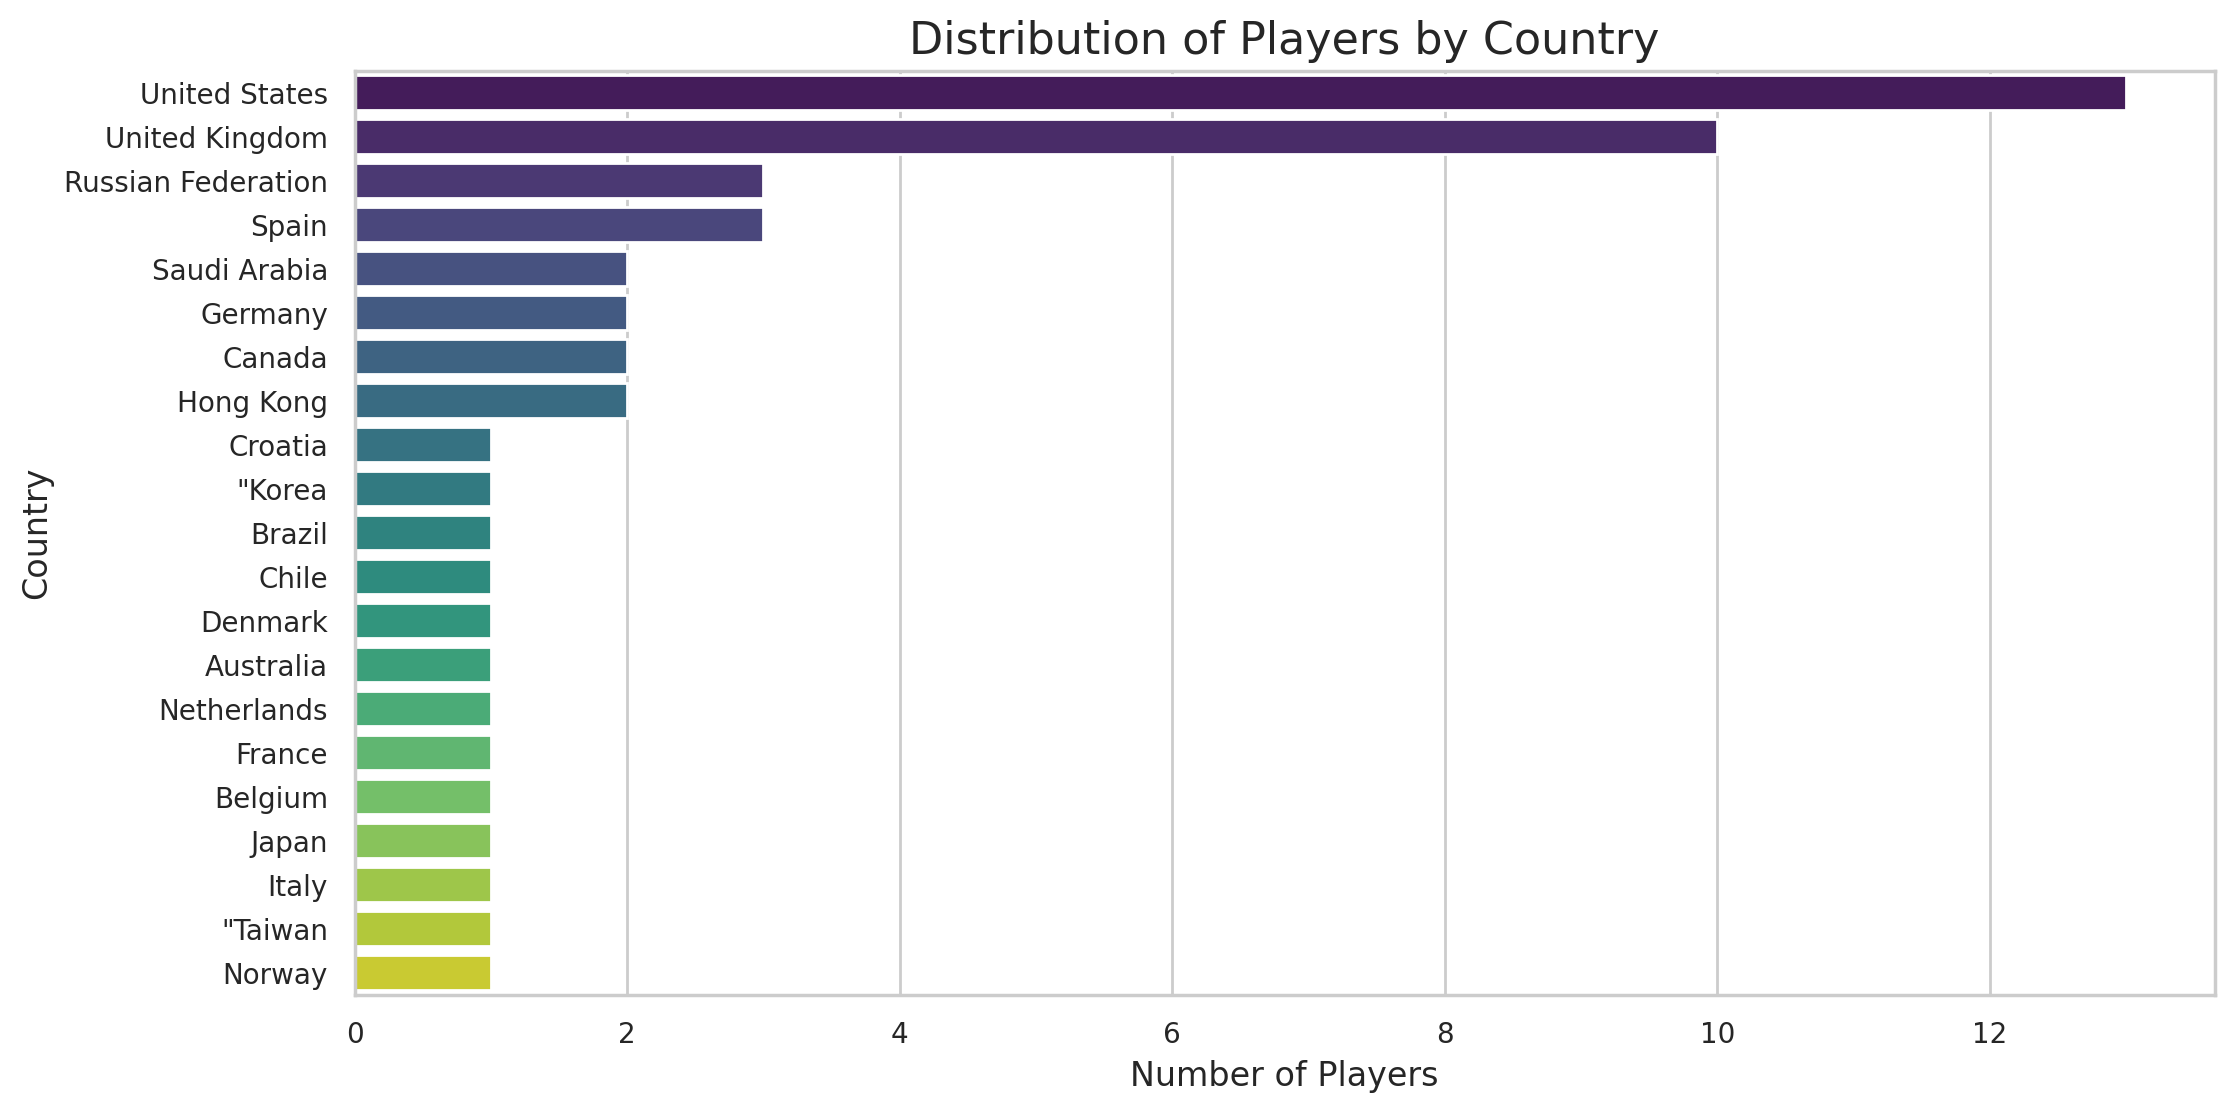

In [35]:

# 1. Distribution of Players by Country
plt.figure(figsize=(12, 6))
sns.countplot(y='country', data=df_players, order=df_players['country'].value_counts().index, palette='viridis')
plt.title('Distribution of Players by Country', fontsize=16)
plt.xlabel('Number of Players', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

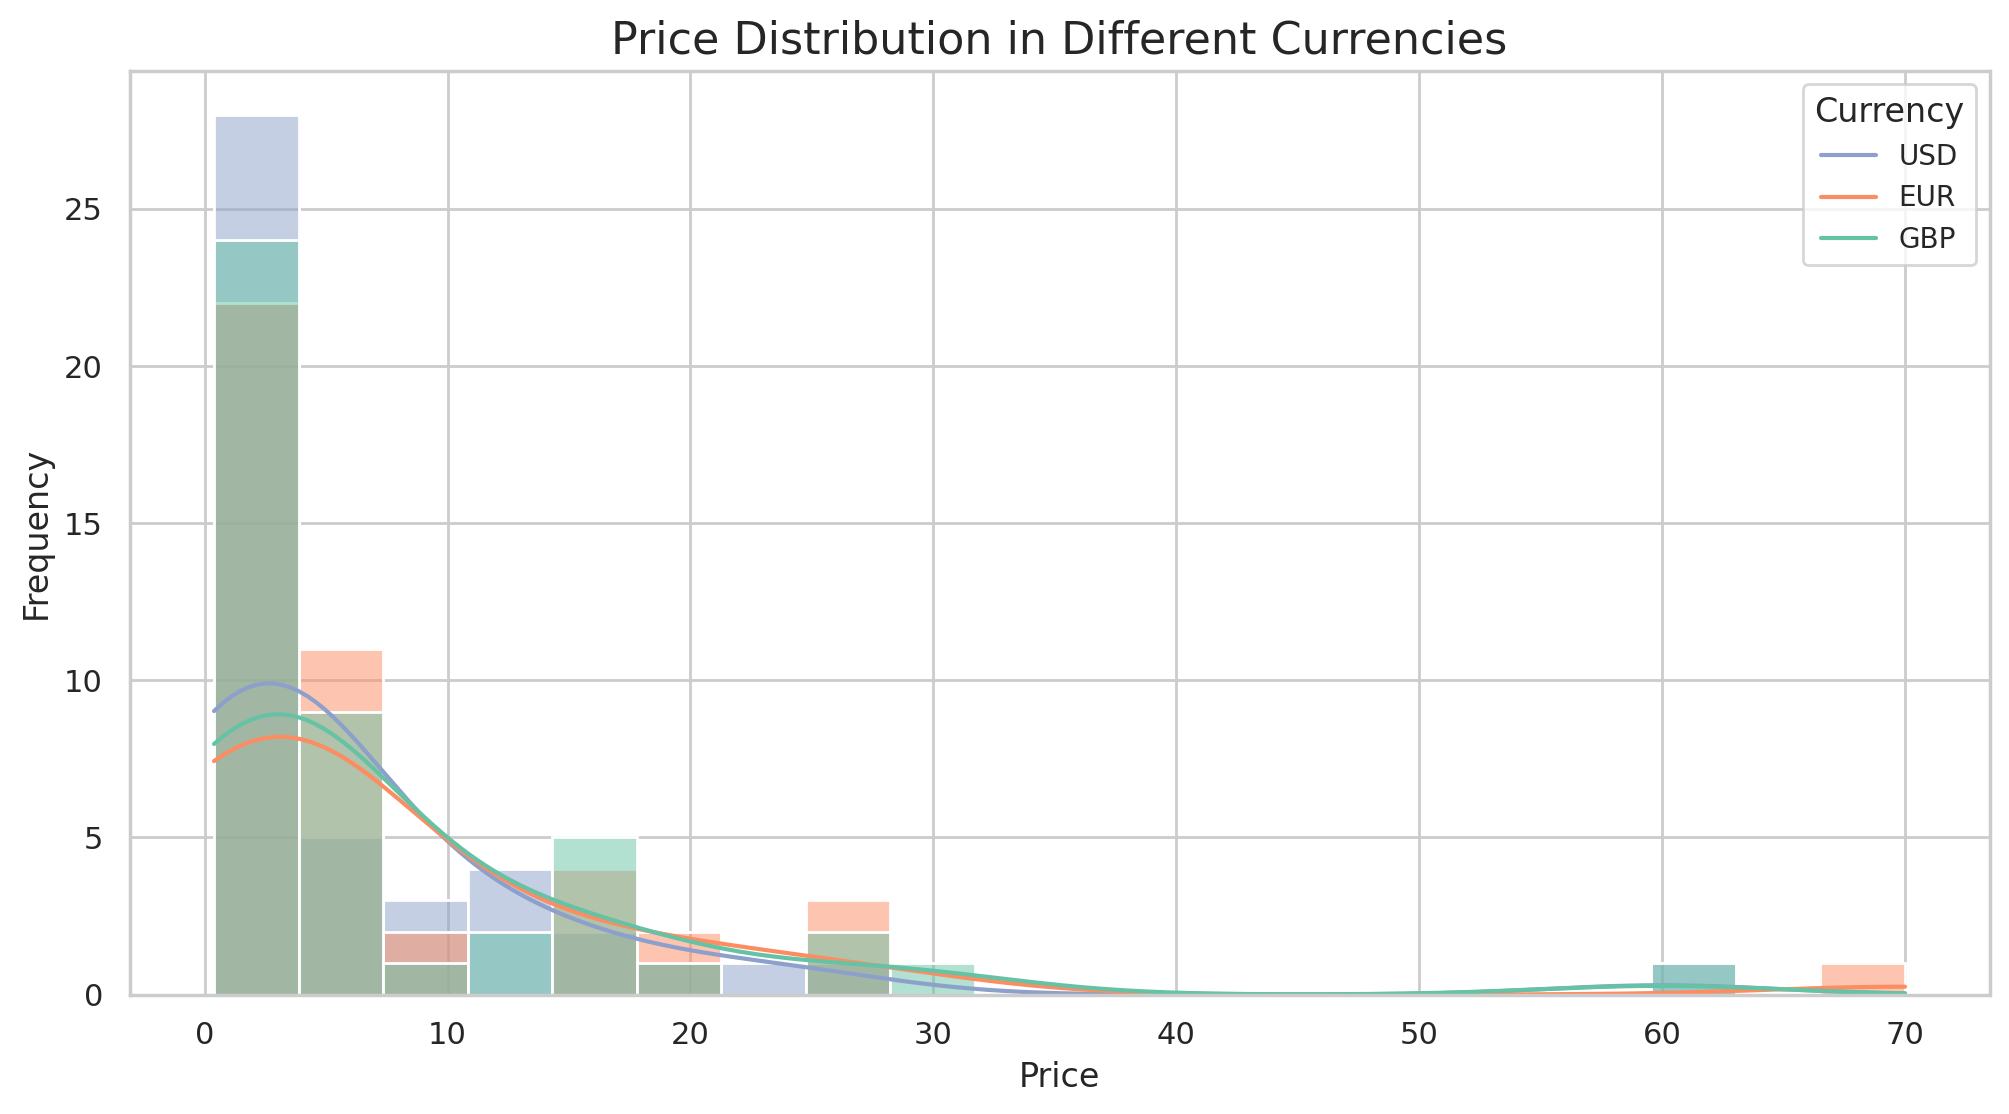

In [36]:
# 2. Price Distribution (USD, EUR, GBP)
plt.figure(figsize=(12, 6))
sns.histplot(df_prices[['usd', 'eur', 'gbp']], kde=True, bins=20, palette="Set2")
plt.title('Price Distribution in Different Currencies', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Currency', labels=['USD', 'EUR', 'GBP'], fontsize=10)
plt.show()